In [1]:
# Preprocessing
import os
from utils import *
import numpy as np
import pandas as pd
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Modeling
from models import BiLSTM_LMCL
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Model
from keras import backend as K

# Evaluation
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import LocalOutlierFactor

# GPU setting
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"
set_allow_growth(device="2")

dataset = "SNIPS"  # [SNIPS, ATIS] Different dataset
proportion = 50 # [25, 50, 75] Different proportion of seen class 
embedding_path = '/data/disk1/sharing/pretrained_embedding/glove/'
EMBEDDING_FILE = os.path.join(embedding_path, 'glove.6B.300d.txt')
MAX_SEQ_LEN = None
MAX_NUM_WORDS = 10000
EMBEDDING_DIM = 300

df, partition_to_n_row = load_data(dataset)
df.head()

/home/tony/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


,text,label
0,listen to westbam alumb allergic on google music,PlayMusic
1,add step to me to the 50 clásicos playlist,AddToPlaylist
2,i give this current textbook a rating value of...,RateBook
3,play the song little robin redbreast,PlayMusic
4,please add iris dement to my playlist this is ...,AddToPlaylist


# Data Preprocessing

In [2]:
df['content_words'] = df['text'].apply(lambda s: word_tokenize(s))
texts = df['content_words'].apply(lambda l: " ".join(l)) 

# Do not filter out "," and "."
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<UNK>", filters='!"#$%&()*+-/:;<=>@[\]^_`{|}~') 

tokenizer.fit_on_texts(texts)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(texts)
sequences_pad = pad_sequences(sequences, maxlen=MAX_SEQ_LEN, padding='post', truncating='post')

# Train-valid-test split
idx_train = (None, partition_to_n_row['train'])
idx_valid = (partition_to_n_row['train'], partition_to_n_row['train'] + partition_to_n_row['valid'])
idx_test = (partition_to_n_row['train'] + partition_to_n_row['valid'], None)

X_train = sequences_pad[idx_train[0]:idx_train[1]]
X_valid = sequences_pad[idx_valid[0]:idx_valid[1]]
X_test = sequences_pad[idx_test[0]:idx_test[1]]

df_train = df[idx_train[0]:idx_train[1]]
df_valid = df[idx_valid[0]:idx_valid[1]]
df_test = df[idx_test[0]:idx_test[1]]

y_train = df_train.label.reset_index(drop=True)
y_valid = df_valid.label.reset_index(drop=True)
y_test = df_test.label.reset_index(drop=True)
print("train : valid : test = %d : %d : %d" % (X_train.shape[0], X_valid.shape[0], X_test.shape[0]))

print("Load pre-trained GloVe embedding...")
MAX_FEATURES = min(MAX_NUM_WORDS, len(word_index)) + 1  # +1 for PAD

def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(EMBEDDING_FILE))
all_embs = np.stack(embeddings_index.values())
emb_mean, emb_std = all_embs.mean(), all_embs.std()
embedding_matrix = np.random.normal(emb_mean, emb_std, (MAX_FEATURES, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_FEATURES: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

train : valid : test = 13084 : 700 : 700
Load pre-trained GloVe embedding...


/home/tony/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


# Modeling - BiLSTM

In [3]:
n_class = y_train.unique().shape[0]
n_class_seen = round(n_class * proportion/100)

weighted_random_sampling = False
if weighted_random_sampling:
    y_cols = y_train.unique()
    y_vc = y_train.value_counts()
    y_vc = y_vc / y_vc.sum()
    y_cols_seen = np.random.choice(y_vc.index, n_class_seen, p=y_vc.values, replace=False)
    y_cols_unseen = [y_col for y_col in y_cols if y_col not in y_cols_seen]
else:
    y_cols_seen = y_train.value_counts().index[:n_class_seen]
    y_cols_unseen = y_train.value_counts().index[n_class_seen:]
print(y_cols_seen)

train_seen_idx = y_train[y_train.isin(y_cols_seen)].index
valid_seen_idx = y_valid[y_valid.isin(y_cols_seen)].index

X_train_seen = X_train[train_seen_idx]
y_train_seen = y_train[train_seen_idx]
X_valid_seen = X_valid[valid_seen_idx]
y_valid_seen = y_valid[valid_seen_idx]

le = LabelEncoder()
le.fit(y_train_seen)
y_train_idx = le.transform(y_train_seen)
y_valid_idx = le.transform(y_valid_seen)
y_train_onehot = to_categorical(y_train_idx)
y_valid_onehot = to_categorical(y_valid_idx)

y_test_mask = y_test.copy()
y_test_mask[y_test_mask.isin(y_cols_unseen)] = 'unseen'

filepath = 'data/BiLSTM_' + dataset + "_" + str(proportion) + '-AM.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, 
                             save_best_only=True, mode='auto', save_weights_only=False)
early_stop = EarlyStopping(monitor='val_loss', patience=20, mode='auto') 
callbacks_list = [checkpoint, early_stop]

train_data = (X_train_seen, y_train_onehot)
valid_data = (X_valid_seen, y_valid_onehot)
test_data = (X_test, y_test_mask)

## If you want to plot the model
# model = BiLSTM_LMCL(MAX_SEQ_LEN, MAX_FEATURES, EMBEDDING_DIM, n_class_seen, 'img/model.png', embedding_matrix)
model = BiLSTM_LMCL(MAX_SEQ_LEN, MAX_FEATURES, EMBEDDING_DIM, n_class_seen, None, embedding_matrix)
history = model.fit(train_data[0], train_data[1], epochs=200, batch_size=256, 
                    validation_data=valid_data, shuffle=True, verbose=2, callbacks=callbacks_list)

['PlayMusic' 'SearchScreeningEvent' 'GetWeather' 'RateBook']
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

Train on 7538 samples, validate on 400 samples
Epoch 1/200
7538/7538 [==============================] - 14s 2ms/step - loss: 6.1266 - acc: 0.9333 - val_loss: 1.0696 - val_acc: 0.9875
Epoch 2/200
7538/7538 [==============================] - 9s 1ms/step - loss: 3.8133 - acc: 0.9987 - val_loss: 0.7375 - val_acc: 0.9975
Epoch 3/200
7538/7538 [==============================] - 11s 1ms/step - loss: 3.6728 - acc: 0.9993 - val_loss: 0.6952 - val_acc: 0.9975
Epoch 4/200
7538/7538 [==============================] - 11s 2ms/step - loss: 3.5941 - acc: 0.9995 - val_loss: 0.6662 - val_acc: 0.9975
Epoch 5/200
7538/7538 [==============================] - 11s 1ms/step - loss: 3.5611 - acc: 1.0000 - val_loss: 0.6293 - val_acc: 0.9975
Epoch 6/200
7538/7538

# Evaluation

Overall(macro):  85.61
Seen(macro):  86.05
=====> Uneen(Experiment) <=====:  83.85
Confusion matrix, without normalization


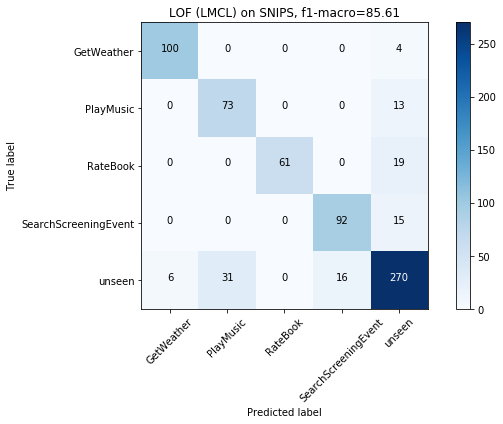

In [4]:
y_pred_proba = model.predict(test_data[0])
y_pred_proba_train = model.predict(train_data[0])
classes = list(le.classes_) + ['unseen']

method = 'LOF (LMCL)'
get_deep_feature = Model(inputs=model.input, 
                         outputs=model.layers[-3].output)
feature_test = get_deep_feature.predict(test_data[0])
feature_train = get_deep_feature.predict(train_data[0])
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05, novelty=True, n_jobs=-1)
lof.fit(feature_train)

y_pred_lof = pd.Series(lof.predict(feature_test))
df_seen = pd.DataFrame(y_pred_proba, columns=le.classes_)
df_seen['unseen'] = 0

y_pred = df_seen.idxmax(axis=1)
y_pred[y_pred_lof[y_pred_lof==-1].index]='unseen'
cm = confusion_matrix(test_data[1], y_pred, classes)

f, f_seen, f_unseen = get_score(cm)
plot_confusion_matrix(cm, classes, normalize=False, figsize=(9, 6),
                      title=method +' on ' + dataset + ', f1-macro=' + str(f))